In [1]:
# Import the required libraries and dependencies
import os
import requests
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [2]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
load_dotenv()

True

In [3]:
# Set the variables for the Alpaca API and secret keys
alpaca_api_key = os.getenv('ALPACA_API_KEY')
alpaca_secret_key = os.getenv('ALPACA_SECRET_KEY')

# Create the Alpaca tradeapi.REST object
alpaca = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version = "v2")

In [4]:
# Set the tickers for both the bond and stock portion of the portfolio
#SPY = S&P500
#AGG= Core US Aggregate Bond ETF
#QQQ= QQQ tracks a modified-market-cap-weighted index of 100 NASDAQ-listed stocks.
#VTV= Value ETF (Provides a convenient way to match the performance of many of the nation’s largest value stocks), 
#IEMG = Emerging Market ETF
#IWM = Russell 2000 index ETF (small cap)
tickers = ['SPY', 'AGG', 'QQQ','VTV', 'IEMG', 'IWM']

# Set timeframe to 1D 
timeframe = "1Day"

# Format current date as ISO format
# Set both the start and end date at the date of your prior weekday 
# This will give you the closing price of the previous trading day
# Alternatively you can use a start and end date of 2020-08-07
start_date = pd.Timestamp("2017-01-01T00:00:00", tz = "America/Los_Angeles").isoformat()
end_date = pd.Timestamp("2021-12-31T00:00:00", tz = "America/Los_Angeles").isoformat()




In [5]:
# Use the Alpaca get_barset function to get current closing prices the portfolio
# Be sure to set the `df` property after the function to format the response object as a DataFrame
data = alpaca.get_bars(tickers, timeframe, start=start_date, end=end_date).df
data.set_index("symbol", inplace = True)

limit_rows = 10000
# Review the first 5 rows of the Alpaca DataFrame
# YOUR CODE HERE
data

,open,high,low,close,volume,trade_count,vwap
symbol,,,,,,,
AGG,107.73,108.2200,107.7300,108.17,5079339,18326,108.035201
AGG,108.16,108.2100,108.0300,108.20,3297075,14047,108.123118
AGG,108.37,108.6800,108.2201,108.65,5165933,17041,108.555340
AGG,108.43,108.5000,108.2600,108.29,2910119,12914,108.333338
AGG,108.54,108.5400,108.4300,108.47,3030497,11744,108.492390
...,...,...,...,...,...,...,...
VTV,145.37,146.5800,145.1100,146.57,2297416,21779,146.016099
VTV,146.59,147.3290,146.5300,146.94,2216919,23599,146.965109
VTV,146.96,147.5500,146.8001,147.24,2322506,22118,147.214942


In [6]:
# Use the Alpaca get_barset function to make the API call to get the 5 years worth of pricing data
# The tickers and timeframe parameters should have been set in Part 1 of this activity 
# The start and end dates should be updated with the information set above
# Remember to add the df property to the end of the call so the response is returned as a DataFrame

def sorter(str1):
    df1 = alpaca.get_bars(str1, 
                          timeframe, 
                          start=start_date, 
                          end=end_date, 
                          limit=limit_rows).df
    col_names = [(str1, x) for x in df1.columns]
    df1.columns = pd.MultiIndex.from_tuples(col_names)
    return df1;

    
def merger(df1, df2):
        prices_merged = pd.merge(df1, df2, how = "inner", left_index=True, right_index=True)
        return prices_merged;

prices_AGG_df = sorter('AGG')
prices_SPY_df = sorter('SPY')
prices_QQQ_df = sorter('QQQ')
prices_VTV_df = sorter('VTV')
prices_IEMG_df = sorter('IEMG')
prices_IWM_df = sorter('IWM')

#tickersdf = [prices_AGG_df, prices_SPY_df, prices_QQQ_df, prices_VTV_df, prices_IEMG_df, prices_IWM_df]

#mergers the data into the form for MCsimulation - this can be done better with some loop logic, I'll clean it up this week
prices_merged = merger(prices_AGG_df, prices_SPY_df)
prices_merged = merger(prices_merged, prices_QQQ_df)
prices_merged = merger(prices_merged, prices_VTV_df)
prices_merged = merger(prices_merged, prices_IEMG_df)
prices_merged = merger(prices_merged, prices_IWM_df)

#prices_merged = merger(list_data)
display(prices_merged.head())  
display(prices_merged.tail())  

AGG                                     \
                             open    high       low   close   volume   
timestamp                                                              
2017-01-03 05:00:00+00:00  107.73  108.22  107.7300  108.17  5079339   
2017-01-04 05:00:00+00:00  108.16  108.21  108.0300  108.20  3297075   
2017-01-05 05:00:00+00:00  108.37  108.68  108.2201  108.65  5165933   
2017-01-06 05:00:00+00:00  108.43  108.50  108.2600  108.29  2910119   
2017-01-09 05:00:00+00:00  108.54  108.54  108.4300  108.47  3030497   

                                                      SPY                      \
                          trade_count        vwap    open      high       low   
timestamp                                                                       
2017-01-03 05:00:00+00:00       18326  108.035201  225.07  225.8300  223.8837   
2017-01-04 05:00:00+00:00       14047  108.123118  225.64  226.7500  225.6100   
2017-01-05 05:00:00+00:00       17041  108.555340  226.28  226.5800  225.4800   
2017-01-06 05:00:00+00:00       12914  108.333338  226.53  227.7500  225.9000   
2017-01-09 05:00:00+00:00       11744  108.492390  226.90  227.0701  226.4163   

                           ...     IEMG                            IWM  \
                           ...   volume trade_count       vwap    open   
timestamp                  ...                                           
2017-01-03 05:00:00+00:00  ...  7008609       21534  42.880855  136.52   
2017-01-04 05:00:00+00:00  ...  5154644       22121  43.244844  136.05   
2017-01-05 05:00:00+00:00  ...  5440393       16873  43.720961  137.50   
2017-01-06 05:00:00+00:00  ...  7137810       27035  43.561160  136.41   
2017-01-09 05:00:00+00:00  ...  4767580       17904  43.551103  135.54   

                                                                           \
                               high     low   close    volume trade_count   
timestamp                                                                   
2017-01-03 05:00:00+00:00  136.8295  134.50  135.52  29792446      125905   
2017-01-04 05:00:00+00:00  137.9600  136.01  137.78  34499365      139192   
2017-01-05 05:00:00+00:00  137.7600  135.51  136.19  30286876      123714   
2017-01-06 05:00:00+00:00  136.7100  135.68  135.69  23435995       97449   
2017-01-09 05:00:00+00:00  135.7200  134.50  134.80  24013865       99844   

                                       
                                 vwap  
timestamp                              
2017-01-03 05:00:00+00:00  135.469157  
2017-01-04 05:00:00+00:00  137.292887  
2017-01-05 05:00:00+00:00  136.444733  
2017-01-06 05:00:00+00:00  136.110436  
2017-01-09 05:00:00+00:00  135.105597  

[5 rows x 42 columns]

AGG                                   \
                             open    high     low   close   volume   
timestamp                                                            
2021-12-27 05:00:00+00:00  114.15  114.30  114.13  114.26  5436338   
2021-12-28 05:00:00+00:00  114.43  114.45  114.17  114.21  5253785   
2021-12-29 05:00:00+00:00  113.99  114.05  113.81  113.87  5929458   
2021-12-30 05:00:00+00:00  113.99  114.13  113.83  114.12  5455434   
2021-12-31 05:00:00+00:00  114.15  114.31  114.06  114.08  7989516   

                                                      SPY                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2021-12-27 05:00:00+00:00       14793  114.244790  472.09  477.31  472.01   
2021-12-28 05:00:00+00:00       15633  114.296552  477.80  478.81  476.06   
2021-12-29 05:00:00+00:00       17375  113.917371  477.04  478.56  475.92   
2021-12-30 05:00:00+00:00       15929  114.004984  477.98  479.00  475.67   
2021-12-31 05:00:00+00:00       17453  114.148781  475.62  476.86  474.67   

                           ...      IEMG                            IWM  \
                           ...    volume trade_count       vwap    open   
timestamp                  ...                                            
2021-12-27 05:00:00+00:00  ...  11090853       93691  59.811476  222.36   
2021-12-28 05:00:00+00:00  ...   9087007       38144  59.739180  223.76   
2021-12-29 05:00:00+00:00  ...  12062721       39303  59.408562  222.73   
2021-12-30 05:00:00+00:00  ...  12793456       51783  59.987205  222.96   
2021-12-31 05:00:00+00:00  ...  14085723       47495  60.058062  222.40   

                                                                            \
                               high      low   close    volume trade_count   
timestamp                                                                    
2021-12-27 05:00:00+00:00  224.2350  220.600  224.12  23954111      188717   
2021-12-28 05:00:00+00:00  225.7300  222.350  222.75  23098737      217256   
2021-12-29 05:00:00+00:00  223.4901  221.255  222.99  19414344      164325   
2021-12-30 05:00:00+00:00  225.4300  222.700  222.93  24518213      204871   
2021-12-31 05:00:00+00:00  224.1200  222.390  222.45  24045329      204415   

                                       
                                 vwap  
timestamp                              
2021-12-27 05:00:00+00:00  222.898587  
2021-12-28 05:00:00+00:00  223.719412  
2021-12-29 05:00:00+00:00  222.616135  
2021-12-30 05:00:00+00:00  224.341669  
2021-12-31 05:00:00+00:00  223.045940  

[5 rows x 42 columns]

In [140]:
# Configure the Monte Carlo simulation to forecast 30 years cumulative returns
# The weights should be split 40% to AGG and 60% to SPY.
# Run 500 samples.
MC_equal_weight = MCSimulation(
    portfolio_data = prices_merged,
    num_simulation = 500,
    num_trading_days = 252*30
)

# Review the simulation input data
# Printing the first five rows of the simulation input data
MC_equal_weight.portfolio_data.head()

AGG                                     \
                             open    high       low   close   volume   
timestamp                                                              
2017-01-03 05:00:00+00:00  107.73  108.22  107.7300  108.17  5079339   
2017-01-04 05:00:00+00:00  108.16  108.21  108.0300  108.20  3297075   
2017-01-05 05:00:00+00:00  108.37  108.68  108.2201  108.65  5165933   
2017-01-06 05:00:00+00:00  108.43  108.50  108.2600  108.29  2910119   
2017-01-09 05:00:00+00:00  108.54  108.54  108.4300  108.47  3030497   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2017-01-03 05:00:00+00:00       18326  108.035201          NaN  225.07   
2017-01-04 05:00:00+00:00       14047  108.123118     0.000277  225.64   
2017-01-05 05:00:00+00:00       17041  108.555340     0.004159  226.28   
2017-01-06 05:00:00+00:00       12914  108.333338    -0.003313  226.53   
2017-01-09 05:00:00+00:00       11744  108.492390     0.001662  226.90   

                                     ...       IEMG                  IWM  \
                               high  ...       vwap daily_return    open   
timestamp                            ...                                   
2017-01-03 05:00:00+00:00  225.8300  ...  42.880855          NaN  136.52   
2017-01-04 05:00:00+00:00  226.7500  ...  43.244844     0.008856  136.05   
2017-01-05 05:00:00+00:00  226.5800  ...  43.720961     0.011550  137.50   
2017-01-06 05:00:00+00:00  227.7500  ...  43.561160    -0.004567  136.41   
2017-01-09 05:00:00+00:00  227.0701  ...  43.551103    -0.002294  135.54   

                                                                           \
                               high     low   close    volume trade_count   
timestamp                                                                   
2017-01-03 05:00:00+00:00  136.8295  134.50  135.52  29792446      125905   
2017-01-04 05:00:00+00:00  137.9600  136.01  137.78  34499365      139192   
2017-01-05 05:00:00+00:00  137.7600  135.51  136.19  30286876      123714   
2017-01-06 05:00:00+00:00  136.7100  135.68  135.69  23435995       97449   
2017-01-09 05:00:00+00:00  135.7200  134.50  134.80  24013865       99844   

                                                    
                                 vwap daily_return  
timestamp                                           
2017-01-03 05:00:00+00:00  135.469157          NaN  
2017-01-04 05:00:00+00:00  137.292887     0.016677  
2017-01-05 05:00:00+00:00  136.444733    -0.011540  
2017-01-06 05:00:00+00:00  136.110436    -0.003671  
2017-01-09 05:00:00+00:00  135.105597    -0.006559  

[5 rows x 48 columns]

In [141]:
MC_equal_weight.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\gitrepo\Fintech_Workspace\Python_Project\Project_1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004441,0.998309,0.998548,0.992862,1.000921,1.003826,0.993689,0.998214,1.006996,0.991217,...,0.999235,0.996926,1.001506,0.997126,0.995767,0.997938,0.995362,0.995646,1.002970,1.006582
2,1.000557,0.990492,1.001544,0.992798,0.995948,1.004983,0.991109,1.001951,1.001015,0.991446,...,1.005722,1.001626,0.996033,0.989574,0.998852,0.996732,0.995502,0.997448,0.998849,1.002313
3,0.997188,0.990698,1.005054,0.991496,0.992026,0.993535,0.988476,1.002540,1.002426,0.990788,...,1.012572,1.005750,1.004380,0.976667,0.998068,1.002301,1.001995,0.993775,0.998957,1.000517
4,0.988559,0.990209,1.003068,0.997266,0.990939,0.989278,0.992227,0.994949,0.999427,0.991828,...,1.011660,1.005517,1.005286,0.983125,1.003080,0.995850,0.996127,0.990623,0.995423,0.999990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,177.757093,26.326029,18.616013,43.232911,28.544250,101.588083,44.307943,17.236132,41.839587,43.388137,...,29.767366,49.988759,57.024155,54.849081,55.286110,38.659190,40.609608,62.100906,52.535448,65.650104
7557,177.287678,26.241390,18.704319,43.095337,28.515928,102.181997,44.290799,17.330773,41.495905,43.552774,...,29.713261,50.415101,56.656857,55.335900,55.598380,38.786207,40.446224,61.701145,52.201528,65.766980
7558,177.207556,26.206662,18.652295,42.965888,28.427826,101.769330,44.383836,17.189111,41.632587,43.647414,...,29.878898,50.374023,56.431974,55.448903,55.519971,38.630669,40.592361,61.083546,51.742588,66.411181
7559,175.821568,26.257774,18.645443,42.935475,28.468915,101.317148,44.103334,17.168817,41.624490,43.631721,...,29.865664,50.405828,56.829818,55.295624,55.047872,38.584587,40.238460,60.958038,51.748088,67.529801


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\gitrepo\Fintech_Workspace\Python_Project\Project_1\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

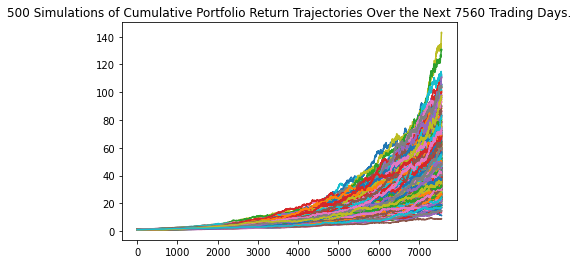

In [142]:
MC_equal_weight_plot = MC_6040_weight.plot_simulation()